In [1]:
import pandas as pd
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx
import rasterio
from rasterio.crs import CRS
from rasterio.transform import from_bounds
from shapely.geometry import box, Point, Polygon, MultiPolygon
from scipy.spatial import cKDTree
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,WhiteKernel,ConstantKernel
from flood_density.plots import convert_kml_to_geojson
from flood_density.preprocess import extract_city_bounds, extract_bounds_polygon, polygon_to_geodataframe, extract_city_data, coordinates_to_box,points_geocoordinates,convert_points_in_gdf, extract_city_bounds_from_dataframe_to_geodataframe

from typing import List, Tuple

CRS_4326 = 4326


# Etapa 1 : Obtener datos .kml de la ciudad de La Plata.

/home/andy/.local/lib/python3.10/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'laplata_cascourbano.kml': 'La Plata' (default), 'La Plata (#2)', 'La Plata (#3)'. Specify layer parameter to avoid this warning.
  result = read_func(


'salida.geojson'

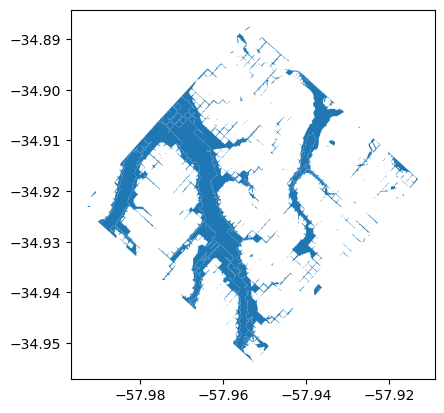

In [2]:
convert_kml_to_geojson("laplata_cascourbano.kml", "salida.geojson")

# Etapa 2: Obtener las coordenadas de los puntos de la ciudad


In [3]:
#¿Cómo obtengo bounds_dict? son coordenadas de la ciudad de La Plata Desde el archivo geojson

In [4]:
# Cargar el archivo GeoJSON del plot
gdf_la_plata = gpd.read_file("salida.geojson")

In [5]:
#Extraemos las coordenadas geográficas de la ciudad 
city_bounds_coordinates= extract_city_bounds(gdf_la_plata)
city_bounds_coordinates

{'x_min': -57.992667,
 'y_min': -34.953843,
 'x_max': -57.91312,
 'y_max': -34.887489}

In [6]:
# Extraemos el polígono de los límites de la ciudad
#polygon_coords = extract_bounds_polygon(city_bounds_coordinates)

In [7]:
#type(polygon_coords)

In [8]:
# Convertimos el polígono a un GeoDataFrame
#geo_polygon = polygon_to_geodataframe(polygon_coords, CRS_4326)

In [9]:
#def convert_gdf_to_geojson(gdf: gpd.GeoDataFrame, output_file: str) -> None:
#    gdf.to_file(output_file, driver='GeoJSON')
#        return gdf.plot()

In [10]:
#convert_gdf_to_geojson(geo_polygon, "polygon.geojson")

In [11]:
city_bounds_coordinates

{'x_min': -57.992667,
 'y_min': -34.953843,
 'x_max': -57.91312,
 'y_max': -34.887489}

In [12]:
# Convertimos las coordenadas de la ciudad a un box
boxx = coordinates_to_box(city_bounds_coordinates)

In [13]:
# Create GeoDataFrame from the bounding box
gdf_la_plata = gpd.GeoDataFrame({'geometry': [boxx]}, crs='EPSG:4326')

# Display the result
#gdf_la_plata.to_file("la_plata_bounds.geojson", driver='GeoJSON')

# Etapa 3 : Obtener y transformar datos de densidad poblacional de la ciudad de La Plata.

Primero extraemos las filas que pertenecen a la ciudad de La Plata(sigue siendo un .csv), luego convertimos ese dataframe en un geodataframe.

In [14]:
#Levantamos el dataset completo
df_arg = pd.read_csv("arg_pd_2020_1km_ASCII_XYZ.csv")

In [15]:
# Extraemos las filas referidas a la ciudad de La Plata
df_lp_coordinates = extract_city_data(df_arg,'la_plata',city_bounds_coordinates)


In [16]:
df_lp_coordinates

,X,Y,Z
2005769,-57.988750,-34.887916,4390.450195
2005770,-57.980416,-34.887916,4219.690918
2005771,-57.972083,-34.887916,3577.566895
2005772,-57.963750,-34.887916,4450.521973
2005773,-57.955416,-34.887916,3841.554199
...,...,...,...
2016355,-57.947083,-34.946250,4543.715820
2016356,-57.938750,-34.946250,4086.931885
2016357,-57.930416,-34.946250,3947.445801
2016358,-57.922083,-34.946250,3537.828613


In [17]:
#Leemos los datos específicos de la ciudad de La Plata
df_lp_coordinates = pd.read_csv('la_plata_population_2020.csv')


In [18]:
df_lp_coordinates

,X,Y,Z
0,-57.988750,-34.887916,4390.450195
1,-57.980416,-34.887916,4219.690918
2,-57.972083,-34.887916,3577.566895
3,-57.963750,-34.887916,4450.521973
4,-57.955416,-34.887916,3841.554199
...,...,...,...
75,-57.947083,-34.946250,4543.715820
76,-57.938750,-34.946250,4086.931885
77,-57.930416,-34.946250,3947.445801
78,-57.922083,-34.946250,3537.828613


In [19]:
#Convertir dataframe de los puntos pertenecientes a la ciudad de La Plata en un geodataframe
gdf_lp_coordinates = extract_city_bounds_from_dataframe_to_geodataframe(df_lp_coordinates, 'Y','X')

In [20]:
gdf_lp_coordinates

,X,Y,Z,geometry
0,-57.988750,-34.887916,4390.450195,POINT (-57.98875 -34.88792)
1,-57.980416,-34.887916,4219.690918,POINT (-57.98042 -34.88792)
2,-57.972083,-34.887916,3577.566895,POINT (-57.97208 -34.88792)
3,-57.963750,-34.887916,4450.521973,POINT (-57.96375 -34.88792)
4,-57.955416,-34.887916,3841.554199,POINT (-57.95542 -34.88792)
...,...,...,...,...
75,-57.947083,-34.946250,4543.715820,POINT (-57.94708 -34.94625)
76,-57.938750,-34.946250,4086.931885,POINT (-57.93875 -34.94625)
77,-57.930416,-34.946250,3947.445801,POINT (-57.93042 -34.94625)
78,-57.922083,-34.946250,3537.828613,POINT (-57.92208 -34.94625)


In [21]:
#TODO : PASAR AL MODULO PREPROCESS.PY UNAVEZ QUE FUNCIONE TODO BIEN
def clip_density_to_urban_area(gdf_1: gpd.GeoDataFrame, gdf_2: gpd.GeoDataFrame) -> gpd.GeoDataFrame: 
    # Usar uniones espaciales para mantener solo puntos dentro del casco urbano
    points_in_casco = gpd.sjoin(gdf_1, gdf_2, how='inner', predicate='intersects')
    
    # Limpiar columnas duplicadas del join 
    points_in_casco = points_in_casco.drop(columns=[col for col in points_in_casco.columns if col.endswith('_right')]) 
    
    return points_in_casco

In [22]:
casco_urbano = clip_density_to_urban_area(gdf_la_plata,gdf_lp_coordinates)

In [23]:
casco_urbano.head()

,geometry,X,Y,Z
0,"POLYGON ((-57.91312 -34.95384, -57.91312 -34.8...",-57.988750,-34.946250,3915.700195
0,"POLYGON ((-57.91312 -34.95384, -57.91312 -34.8...",-57.972083,-34.946250,4401.262207
0,"POLYGON ((-57.91312 -34.95384, -57.91312 -34.8...",-57.980416,-34.946250,4424.620117
0,"POLYGON ((-57.91312 -34.95384, -57.91312 -34.8...",-57.963750,-34.937916,4684.019043
0,"POLYGON ((-57.91312 -34.95384, -57.91312 -34.8...",-57.972083,-34.937916,4280.312012


In [ ]:
# Convertir a Web Mercator (sist. de proyección cartográfica EPSG 3857:3d)

,geometry,X,Y,Z
0,"POLYGON ((-6446859.029 -4157610.36, -6446859.0...",-57.988750,-34.946250,3915.700195
0,"POLYGON ((-6446859.029 -4157610.36, -6446859.0...",-57.972083,-34.946250,4401.262207
0,"POLYGON ((-6446859.029 -4157610.36, -6446859.0...",-57.980416,-34.946250,4424.620117
0,"POLYGON ((-6446859.029 -4157610.36, -6446859.0...",-57.963750,-34.937916,4684.019043
0,"POLYGON ((-6446859.029 -4157610.36, -6446859.0...",-57.972083,-34.937916,4280.312012


# Etapa 4: Manipulación del polígono que encierra el casco de la ciudad de La Plata

In [ ]:
#Usar el dataframe del polígono que forma las coordenadas de la LP
gdf_la_plata_from_polygon = gpd.GeoDataFrame({'geometry': [boxx]}, crs='EPSG:3857')


In [35]:
gdf_la_plata_from_polygon

,geometry
0,"POLYGON ((-57.913 -34.954, -57.913 -34.887, -5..."


gdf_la_plata_utm es la conversión de gdf_la_plata_from_polygon a metros, pero no la efectiviza

# Etapa 5 : Extraer los puntos de densidad que pertenecen al casco de la ciudad de La Plata

In [26]:
# Coordenadas de centroides
#coords = np.array([[point.x, point.y] for point in casco_utm.geometry.centroid])
#values_density = casco_utm['Z'].values

In [27]:
#Extraer los límites
#bounds = gdf_la_plata_from_polygon.total_bounds  # [minx, miny, maxx, maxy]


In [28]:
casco_utm = casco_utm.to_crs(epsg=3857)
gdf_la_plata_from_polygon = gdf_la_plata_from_polygon.to_crs(epsg=3857)

coords = np.array([[geom.centroid.x, geom.centroid.y] for geom in casco_utm.geometry])

bounds = gdf_la_plata_from_polygon.total_bounds  # ahora sí en metros
values_density = casco_utm['Z'].values

gdf_la_plata_from_polygon está en grados, no en metros.

#PROBLEMA DETECTADO: bounds no está en metros, sino en grados.

# Etapa 6 : Merge polígono y zona de densidad de la ciudad de La Plata usando Open Street Map

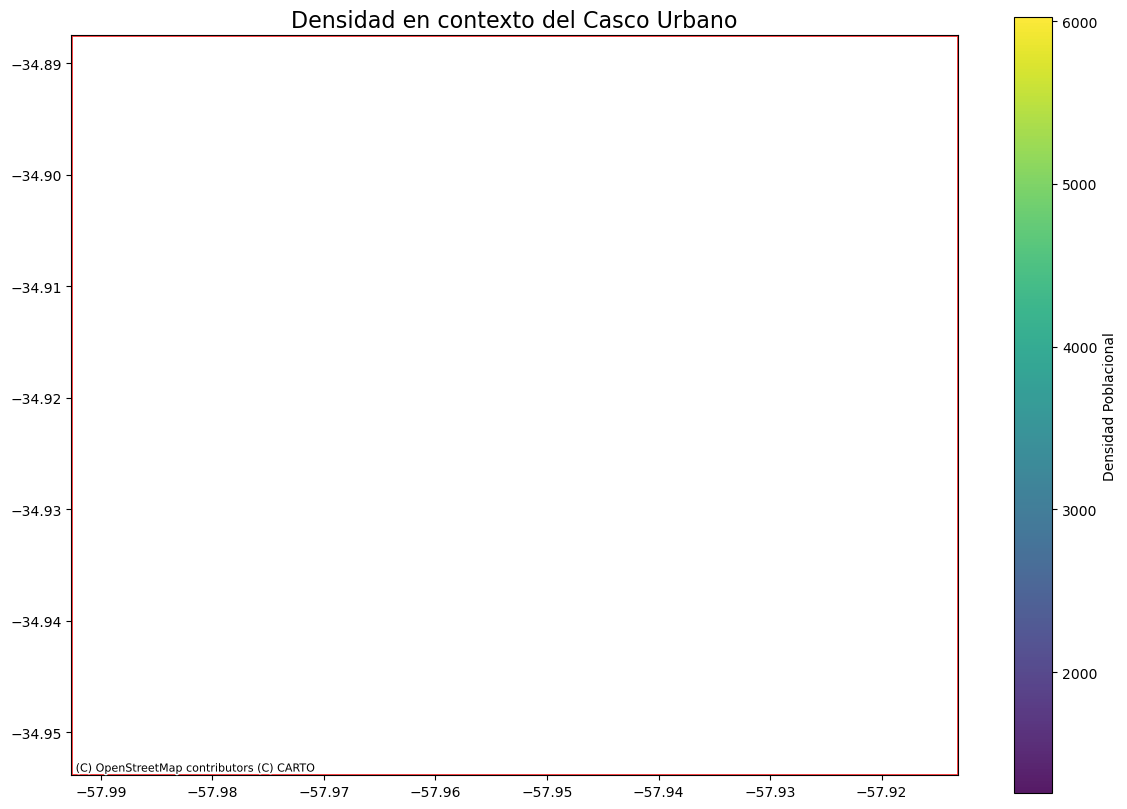

In [29]:

bounds = gdf_la_plata_from_polygon.total_bounds

fig, ax = plt.subplots(figsize=(12, 10))

try:
    ctx.add_basemap(ax, crs='EPSG:3857', 
                    source=ctx.providers.CartoDB.Positron,
                    zoom=12,  # Zoom para área urbana
                    alpha=0.7)
except Exception as e:
    print(f"Error: {e}")

# Plot polígono
gdf_la_plata_from_polygon.plot(ax=ax, facecolor='none', edgecolor='red', 
                              linewidth=2, alpha=0.8)

# Plot puntos de densidad (todos en el mismo lugar)
sc = ax.scatter(coords[:, 0], coords[:, 1], 
                c=values_density, s=100,
                cmap='viridis', alpha=0.9, 
                edgecolor='black', linewidth=1,
                marker='o')

# Usar bounds del polígono
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])

plt.colorbar(sc, ax=ax, label='Densidad Poblacional', shrink=0.8)
ax.set_title('Densidad en contexto del Casco Urbano', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Visualización de la densidad poblacional de La Plata usando kriging

# Extraer coordenadas de los centroides,y valores desde el GeoDataFrame
coords =np.array([[point.x, point.y] for point in casco_utm.geometry.centroid]) 
values_density = casco_urbano['densidad_poblacional_lp'].values

print(f"Puntos de datos: {len(coords)}")    
print(f"Rango de valores: {values_density.min():.2f} - {values_density.max():.2f}")

# Crear grid de puntos para interpolación
grid_x, grid_y = np.mgrid[bounds_proj[0]:bounds_proj[2]:150j, bounds_proj[1]:bounds_proj[3]:150j]
grid_coords = np.column_stack([grid_x.ravel(), grid_y.ravel()])

#Definir kernel para el modelo de kriging
kernel = (ConstantKernel(1.0) * RBF(length_scale=1000.0) + 
          WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, 1e3)))

# Crear modelo de kriging
gpr = GaussianProcessRegressor(kernel=kernel,
                                n_restarts_optimizer=10,
                                alpha=1e-04,
                                normalize_y=True)

# Entrenar el modelo
gpr.fit(coords, values_density)

#Predecir en el grid
grid_2_kriging, pred_std = gpr.predict(grid_coords, return_std=True)
grid_z = grid_2_kriging.reshape(grid_x.shape)
grid_uncertainty = pred_std.reshape(grid_x.shape)

# Visualización de la superficie Kriging interpolada
fig, ax = plt.subplots(figsize=(10, 10))

# Plotear superficie Kriging interpolada
contour = ax.contourf(grid_x, grid_y, grid_z, levels=30, cmap='viridis', alpha=0.5)

# Plotear los polígonos originales con bordes
casco_utm.plot(column='densidad_poblacional_lp', 
               cmap='viridis',
               alpha=0.5,
               edgecolor='black',
               linewidth=1.0,
               ax=ax)

# Plotear los puntos centroides
scatter = ax.scatter(coords[:, 0], coords[:, 1],
                    c=values_density,
                    cmap='viridis',
                    s=30,
                    edgecolors='black',
                    linewidths=1,
                    zorder=5)

# Ajustar límites del gráfico según los límites de La Plata
ax.set_xlim(bounds_proj[0], bounds_proj[2])
ax.set_ylim(bounds_proj[1], bounds_proj[3])

#Mapa base más sutil
ctx.add_basemap(ax, crs=casco_utm.crs.to_string(),
               source=ctx.providers.CartoDB.Positron,
               alpha = 0.9)

# Agregar colorbar para el scatter
plt.colorbar(scatter, ax=ax, label='Densidad poblacional',shrink=0.7, aspect=25)

# Agregar título y etiquetas
ax.set_title('Interpolación Kriging - Densidad Poblacional La Plata')
ax.set_xlabel('X (UTM)')
ax.set_ylabel('Y (UTM)')

plt.tight_layout()
plt.show()

In [ ]:
def export_to_geotiff(grid_data: np.ndarray, gdf: gpd.GeoDataFrame, filename: str, crs_epsg: int = 3857):

     # Crear un GeoDataFrame con los límites del área de La Plata en EPSG:4326
    gdf_bounds_4326 = gpd.GeoDataFrame(geometry=[bbox], crs="EPSG:4326")

    # Transformar al CRS del plot
    gdf_bounds_utm = gdf_bounds_4326.to_crs(casco_utm.crs)

    # Obtener límites en coordenadas proyectadas
    bounds_proj = gdf_bounds_utm.total_bounds  # [xmin, ymin, xmax, ymax]
    height, width = grid_data.shape

    # Calcula la transformación georreferenciada
    transform = from_bounds(bounds_proj[0], bounds_proj[1], bounds_proj[2], bounds_proj[3], width, height)

    with rasterio.open(
        filename,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,
        dtype=grid_data.dtype,
        crs=CRS.from_epsg(crs_epsg),
        transform=transform,
        compress='lzw'
    ) as dst:
        dst.write(grid_data, 1)
        dst.set_band_description(1, 'Densidad Poblacional Kriging')



In [ ]:
# Exportar superficie interpolada
export_to_geotiff(grid_z, gdf_bounds_4326, 'kriging_densidad_poblacional.tif', 3857)

# Etapa 5 : superposición de mapas de densidad y peligrosidad de inundación de la ciudad de La Plata (QGIS).